# DATA EXPLORATION

## 1. Import

In [1]:
import pandas as pd
import numpy as np
import spacy
import itertools
import tensorflow as tf

from nltk.tokenize import word_tokenize
import string

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential


d:\02.Pro\SIMPLON\Formation\S17.S18-NLP_Aout.Sept2022\brief_lyrics_generator\.env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data

In [2]:
df_artists = pd.read_csv('data/artists-data.csv')
df_lyrics = pd.read_csv('data/lyrics-data.csv')

In [3]:
df_artists.head(5)

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [4]:
df_lyrics.tail(5)

,ALink,SName,SLink,Lyric,language
379926,/clegg-johnny/,The Waiting,/clegg-johnny/the-waiting.html,Chorus\nHere we stand waiting on the plain\nDa...,en
379927,/clegg-johnny/,Too Early For The Sky,/clegg-johnny/too-early-for-the-sky.html,I nearly disappeared into the mouth of a croco...,en
379928,/clegg-johnny/,Warsaw 1943 (I Never Betrayed The Revolution),/clegg-johnny/warsaw-1943-i-never-betrayed-the...,"Amambuka, amambuka azothengisa izwe lakithi, i...",en
379929,/clegg-johnny/,When The System Has Fallen,/clegg-johnny/when-the-system-has-fallen.html,Sweat in the heat for days on end\nwaiting for...,en
379930,/clegg-johnny/,Woman Be My Country,/clegg-johnny/woman-be-my-country.html,Here we stand on the edge of the day\nFaces me...,en


## 3. Merge

In [5]:
df_artists.drop(['Songs'], axis=1, inplace=True)
df_lyrics.drop(['SLink'], axis=1, inplace=True)
df_lyrics.rename(columns = {'ALink':'Link', 'language': 'Language'}, inplace = True)
df = pd.merge(left=df_lyrics, right=df_artists, how='right')
df.rename(columns = {'SName':'Title', 'Genres': 'Genre'}, inplace = True)
df.drop(['Link'], axis=1, inplace=True)

In [6]:
df.head(6)

,Title,Lyric,Language,Artist,Genre,Popularity
0,Arerê,"Tudo o que eu quero nessa vida,\nToda vida, é\...",pt,Ivete Sangalo,Pop; Axé; Romântico,4.4
1,Se Eu Não Te Amasse Tanto Assim,Meu coração\nSem direção\nVoando só por voar\n...,pt,Ivete Sangalo,Pop; Axé; Romântico,4.4
2,Céu da Boca,É de babaixá!\nÉ de balacubaca!\nÉ de babaixá!...,pt,Ivete Sangalo,Pop; Axé; Romântico,4.4
3,Quando A Chuva Passar,Quando a chuva passar\n\nPra quê falar\nSe voc...,pt,Ivete Sangalo,Pop; Axé; Romântico,4.4
4,Sorte Grande,A minha sorte grande foi você cair do céu\nMin...,pt,Ivete Sangalo,Pop; Axé; Romântico,4.4
5,A Lua Q Eu T Dei,"Posso te falar dos sonhos, das flores...\nde c...",pt,Ivete Sangalo,Pop; Axé; Romântico,4.4


## 4. Language

In [7]:
top_language = df.Language.describe()['top']
print('top language :', top_language)

top language : en


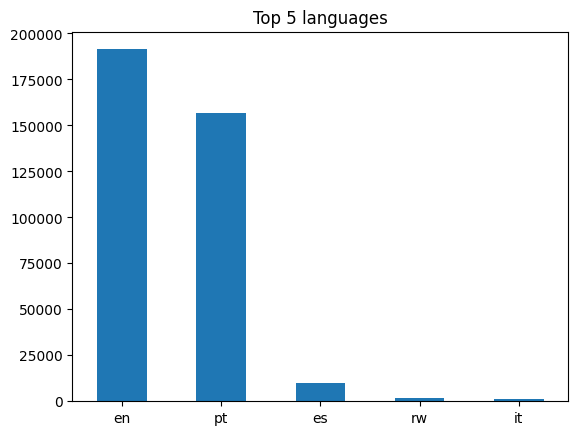

In [8]:
languages = df.Language.value_counts()[:5]
ax = languages.plot.bar(rot=0, title='Top 5 languages')

Nous choisissons l'anglais qui est la langue la plus représentée dans le datatset.

In [9]:
df = df[df.Language == top_language]

## 5. Genre

In [10]:
df.Genre = df.Genre.str.split(';')
df = df.explode('Genre')
df.Genre = df.Genre.str.strip()

In [11]:
top_genre = df.Genre.describe()['top']
print('top genre :', top_genre)

top genre : Rock


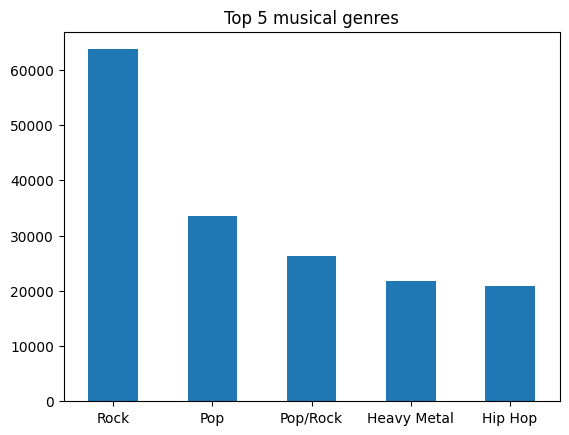

In [12]:
genres = df.Genre.value_counts()[:5]
ax = genres.plot.bar(rot=0, title='Top 5 musical genres')

Nous choisissons le Rock qui est le genre le plus représenté dans le datatset.

In [13]:
df = df[df.Genre == top_genre]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63717 entries, 16609 to 375541
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Title       63717 non-null  object 
 1   Lyric       63717 non-null  object 
 2   Language    63717 non-null  object 
 3   Artist      63717 non-null  object 
 4   Genre       63717 non-null  object 
 5   Popularity  63717 non-null  float64
dtypes: float64(1), object(5)
memory usage: 3.4+ MB


In [21]:
df.to_csv('data/data.txt', index=None, sep=';', mode='a')

## 6. Visualisation

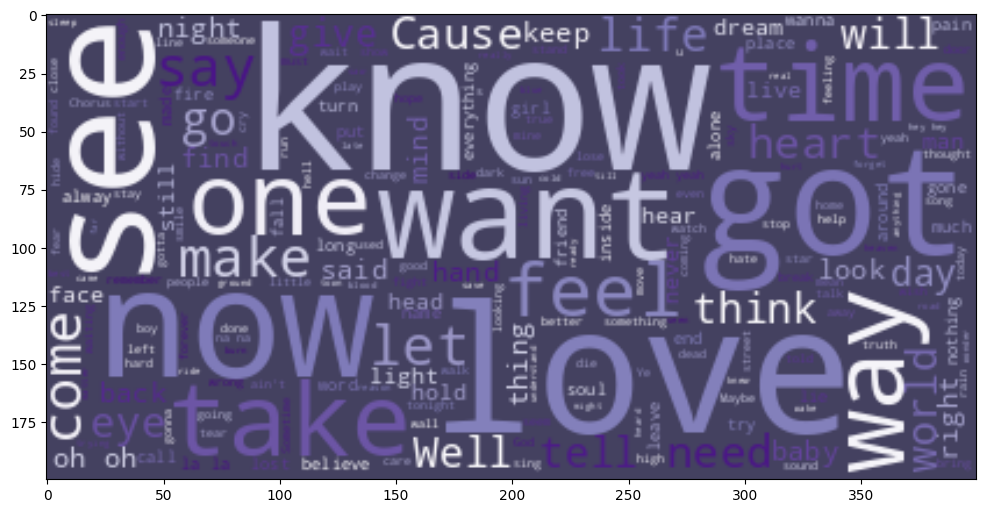

In [15]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
wordcloud = WordCloud(stopwords=set(STOPWORDS), background_color="#444160",colormap="Purples", max_words=800).generate(" ".join(df["Lyric"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()